<a href="https://colab.research.google.com/github/ucfilho/RTC_case_02_optimization/blob/master/RTC_DE_case_02_aproach_H_abril_17_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from scipy.optimize import differential_evolution
import numpy as np
import matplotlib.pyplot as plt

In [0]:
!git clone https://github.com/ucfilho/raianars_RTC_optimization #clonar do Github
%cd raianars_RTC_optimization
import de_bounds_matriz

fatal: destination path 'raianars_RTC_optimization' already exists and is not an empty directory.
/content/raianars_RTC_optimization


In [0]:
# keep the split stream in last position ?????

In [0]:
def SharkBuildMatriz(x):
  # Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha=SharkBuildMatriz(x)
  # add one position in three variables (Ind_J,Ind_I,deltaT)
  # Alfa and Split (split choose the moment and alpha the fraction)
  # Split=which stream
  # Alfa=fraction 
  
  global Trocas
  NPAR=1
  #cols=len(tempInicial)
  size=int(3*Trocas+3) # number 3 represent split, alfa and WhenSplit
  # add one exchange
  x=np.array(x).reshape(1,size)
  # print('x=');print(x)
  Ind_I=np.zeros((NPAR,Trocas)).astype(np.int64)
  Ind_J=np.zeros((NPAR,Trocas)).astype(np.int64)
  
  Tout=np.zeros((NPAR,Trocas))
  deltaT=np.zeros((NPAR,Trocas))
  for i in range(NPAR):
    Alpha=x[i,size-3]
    Split=round(x[i,size-2]).astype(np.int64)
    WhenSplit=round(x[i,size-1]).astype(np.int64)
    for j in range(Trocas):
      #print('[i,j]=%d %d'%(i,j))
      Ind_I[i,j]=round(x[i,j])
      Ind_J[i,j]=round(x[i,j+Trocas])
      deltaT[i,j]=x[i,j+2*Trocas] 
    '''
    for jj in range(cols):
      Tin[i,jj]=tempInicial[jj]
      Tout[i,jj]=tempAtual[jj]
    '''

  return Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha
  #Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha=SharkBuildMatriz(x)

In [0]:
'''
def FixSplit(x):
  
  global Trocas, mCp,  tempInicial, tempAtual, tempAlvo 
  Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha=SharkBuildMatriz(x)
  if(tempInicial[Split]>tempAlvo[Split]):
'''

'\ndef FixSplit(x):\n  \n  global Trocas, mCp,  tempInicial, tempAtual, tempAlvo \n  Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha=SharkBuildMatriz(x)\n  if(tempInicial[Split]>tempAlvo[Split]):\n'

In [0]:
#FUN calcula o TAC para um determinado arranjo
#  cada calculo é feito em uma funcao a parte Fun usa todas funcoes 

def FUN(x):

  global mCp,tempAtual,tempAlvo,tempInicial,U,coefCustoUQ,coefCustoUF
  
  NPAR=1
  '''
  funr=np.zeros((NPAR))
  cols=len(mCp)
  Ind_I,Ind_J,deltaT, Tin, Tout=buildMatriz(x) # transforma x em matriz logica e troca
  Tout, Erro=Temperatura(x)
  areaTrocadores =Area(x)
  areaUtilidade, cargaUQ,cargaUF = Utilidades(tempAlvo,Tout,mCp)
  cost=CustoProcesso(areaTrocadores,areaUtilidade,cargaUF,cargaUQ)
  funr=cost

  for k in range(NPAR):
    if(Erro[k]>0):
      funr[k]=1e99
  funr = np.where(np.isnan(cost), 1e99, cost)
  '''
  funr=1e99 # fake line (temporary)
  return funr 

In [0]:
def Temperatura(x):
  global Trocas, mCp,tempInicial,tempAlvo
  
  #print(tempInicial)
  NPAR=1
  Tin=np.zeros(Trocas)
  Tout=np.zeros((NPAR,Trocas))
  mCpin=np.zeros(Trocas)
  erro=np.zeros((NPAR)) # erro=1 if there  is an error : penalties
  rows=Trocas 
  cols=Trocas
  Rec_Temp=np.zeros((rows+5,cols))# four extra positions to better view and one to split

  Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha=SharkBuildMatriz(x)
  # the parts A, B, C, and D of this routine 
  #     build informations to use x random population or individual (A,B, and C)
  #     use the built information (D)
  #=====================
  # part A: converting WhenSplit in two sequential exchanges (split stream)
  # if WhenSplit is the last it can allocate a position before the last 
  # but it is allocate in a position in advance in other conditions
  if(WhenSplit==Trocas-1):
    Ind_1st=WhenSplit-1
    Ind_2nd=WhenSplit
  else:
    Ind_1st=WhenSplit
    Ind_2nd=WhenSplit+1
  
  #=====================
  # part B: allocating split in cold or hot stream
  # Hot=1 means hot stream is split
  # Hot=0 means hot stream is not split (so cold stream is split)
  if(tempInicial[Split]>tempAlvo[Split]): # hot stream is spliting
    Hot=1 
    Ind_I[0,Ind_1st]=Split # two streams are correct by split information
    Ind_I[0,Ind_2nd]=Split # two streams are correct by split information
  else: # cold stream is spliting
    Hot=0 
    Ind_J[0,Ind_1st]=Split # two streams are correct by split information
    Ind_J[0,Ind_2nd]=Split # two streams are correct by split information

  #=====================
  # part C: bulding mCp with split values and temperatures with split values
  for kk in range(Trocas-1):
    Tin[kk]=tempInicial[kk]
    mCpin[kk]=mCp[kk]

  Tin[Trocas-1]=tempInicial[Trocas-2]
  mCpin[Trocas-1]=mCpin[Trocas-2]

  Aux=np.copy(Tin)
  Aux_cp=np.copy(mCpin)      
  for k in range(Split,Trocas-1):
    Tin[k+1]=Aux[k]
    mCpin[k+1]=Aux_cp[k]

  mCpout=np.copy(mCpin)
  if(Split==Trocas-1):
    mCpout[Split-1]= Alpha*mCpout[Split-2]
    mCpout[Split]= (1-Alpha)*mCpout[Split-1]
  else:
    mCpout[Split]=Alpha*mCpout[Split]
    mCpout[Split+1]= (1-Alpha)*mCpout[Split+1]
  

  for ki in range(NPAR):
    for kj in range(Trocas): 
      Tout[ki,kj]=Tin[kj]

  # Lists Rec_Temp is used to build graph 
  for i in range(2):
    for j in range(cols):
      Rec_Temp[i,j]=np.copy(Tout[0,j])

  Grab=0 #grab is evaluation: 0: no split, 1:start slit, 2:conclude split 
  #=====================
  # part D: start get temperatures using informations build (A,B,C)
  Cont=1
  for ki in range(NPAR):
    for kj in range(Trocas):
      Cont=Cont+1
      k=kj
      i=Ind_I[ki,kj]
      j=Ind_J[ki,kj]

      if(kj==WhenSplit):
        Cp=np.copy(mCpout)
        grab=1
      elif(kj==WhenSplit+1):
        Cp=np.copy(mCpout)
        grab=2
      else:
        Cp=np.copy(mCpin)
        grab=0

      if(WhenSplit==Trocas-1):
        if(kj==Trocas-2):
          Cp=np.copy(mCpout)
          grab=1
        elif(kj==Trocas-1):
          Cp=np.copy(mCpout)
          grab=2
        else:
          Cp=np.copy(mCpin)
          grab=0
     
      tempSaidaQ=Tout[ki,i]+deltaT[ki,kj]
      tempSaidaF=-Cp[kj]*deltaT[ki,kj]/(Cp[j])+Tout[ki,j]
      #print("===%f ====%f"%(tempSaidaF,tempSaidaQ))
      flag=0 # flag : logical test
      # flag instead of several ifs provided better identation (in this case)
      if(Tout[ki,i] > Tout[ki,j]): #Tquente maior Tfria: vaores atuais
        if(tempSaidaQ > tempSaidaF): #Tquente maior Tfria: saidas
          flag=1
      if(flag>0):
        Thot=np.copy(Tout[ki,i]) # value used to return original value (if request)
        Tcold=np.copy(Tout[ki,j]) # value used to return original value (if request)
        Tout[ki,i]=tempSaidaQ
        Tout[ki,j]=tempSaidaF
      else:
        erro[ki]=1
      
      if(grab==2):
        Tout[ki,i]=np.copy(Thot) # return original value
        Tout[ki,j]=np.copy(Tcold) # return original value
        if(kj==Trocas-1):
          if(Hot==1):
        tempSaidaQ=Tout[ki,i]+deltaT[ki,kj]
        tempSaidaF=-Cp[kj]*deltaT[ki,kj]/(Cp[j])+Tout[ki,j+1]

        if(flag>0):

        if(WhenSplit==Trocas-1):
          if(Hot==1):
            i_1st=Ind_I[ki,Trocas-2]
            i_2nd=Ind_I[ki,Trocas-1]
          else:
            i_1st=Ind_J[ki,Trocas-2]
            i_2nd=Ind_J[ki,Trocas-1]

          Taux=Alpha*Tout[ki,i_1st]+(1-Alpha)*Tout[ki,i_1st]
          
          if(Hot==1):
            i_1st=Ind_I[ki,Trocas-2]
            # i_1st=Trocas-2
            i_2nd=Ind_I[ki,Trocas-1]
            # i_2nd=Trocas-1
            Tout[ki,i_1st]=Taux
            Tout[ki,i_2nd]=Taux
          else:
            j_1st=Ind_J[ki,Trocas-2]
            j_2nd=Ind_J[ki,Trocas-1]
            Tout[ki,j_1st]=Taux
            Tout[ki,j_2nd]=Taux
        else: # if(WhenSplit==Trocas-1):
          i=WhenSplit
          Taux=Alpha*Tout[ki,i]+(1-Alpha)*Tout[ki,i+1]
          print('==== Taux=',Taux)
          if(Hot==1):
            i_1st=Ind_I[ki,i]
            i_2nd=Ind_I[ki,i+1]
            Tout[ki,i_1st]=Taux
            Tout[ki,i_2nd]=Taux
          else:
            j_1st=Ind_J[ki,i]
            j_2nd=Ind_J[ki,i+1]
            Tout[ki,j_1st]=Taux
            Tout[ki,j_2nd]=Taux
            
      
      for j in range(cols):
        Rec_Temp[Cont,j]=np.copy(Tout[0,j])
 
  for j in range(cols):
    Rec_Temp[Cont+1,j]=np.copy(Tout[0,j])
    Rec_Temp[Cont+2,j]=np.copy(Tout[0,j])
    
  return Tout,erro,Rec_Temp

  # return Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha # fake return until test
  # return Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha,Tin # fake return until test
  # return Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha,Tin, mCpin # fake return until test
  # return Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha,Tin, mCpin, mCpout # fake return until test

In [0]:
#********************PROGRAMA PRINCIPAL*************************

Trocas=5
mCp=[4,2,1.5,3] #[kW/K]
tempInicial=[453.0,393.0,523.0,533.0] #[K]
tempAtual=np.copy(tempInicial) 
tempAlvo=[513.0,508.0,403.0,433.0] #[K]
U=0.2 #[kW/(m2.K)]
coefCustoUQ=110 #[$/(kW.ano)]
coefCustoUF=12.2 #[$/(kW.ano)]

# the last position in MAX and MIN vector represent which moment the split 
#    occur not which stream (split represent which stream) 
#    for this reason it reach larger value
#MAX=np.array([3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,1,3,4]) # ,1,3,4]) Alpha,Split,WhenSplit
#MIN=np.array([0,0,0,0,0,0,0,0,0,0,-100,-100,-100,-100,-100,0,0,0])

MAX=np.array([3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,1,3,4]) # ,1,3,4]) Alpha,Split,WhenSplit
MIN=np.array([2,2,2,2,2,0,0,0,0,0,-20,-20,-20,-20,-20,0,0,0])
NPAR=1
cols=int(3*Trocas+3)
x=np.zeros((NPAR,cols))

for i in range(NPAR):
  for j in range(cols):
    r=np.random.random()
    x[i,j]=r*(MAX[j]-MIN[j])+MIN[j]





bounds=[]
for k in range(len(MAX)):
  bounds.append((MIN[k],MAX[k]))


#print(bounds)



In [0]:



Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha=SharkBuildMatriz(x)
print(Ind_I)
print(Ind_J)
print(deltaT)
print('Split=',Split)
print(Alpha)
print(WhenSplit)

print('=====================')
Tout,erro,Rec_Temp =Temperatura(x)
df=pd.DataFrame(Rec_Temp)
print(Tout)
print(erro)
print(df)


[[2 2 3 3 2]]
[[1 0 0 0 1]]
[[-10.85043324 -10.34035135  -8.63043577  -1.50128251  -7.81603018]]
Split= 3
0.7734945325797213
1
==== Taux= 436.7735298899542
[[461.40658909 426.42491175 504.33353658 436.77352989 533.        ]]
[1.]
            0           1           2           3      4
0  453.000000  393.000000  523.000000  533.000000  533.0
1  453.000000  393.000000  523.000000  533.000000  533.0
2  453.000000  414.700866  512.149567  533.000000  533.0
3  458.170176  414.700866  512.149567  522.659649  533.0
4  461.406589  414.700866  512.149567  436.773530  533.0
5  461.406589  414.700866  512.149567  436.773530  533.0
6  461.406589  426.424912  504.333537  436.773530  533.0
7  461.406589  426.424912  504.333537  436.773530  533.0
8  461.406589  426.424912  504.333537  436.773530  533.0


In [0]:
print(WhenSplit)

1


Text(0, 0.5, 'Temperature (K)')

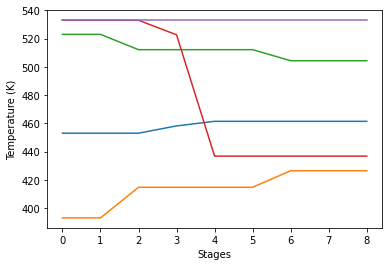

In [0]:
Imagem=Trocas+4 # Imagens+4 to get better graph postions
Change=range(Imagem)
for k in range(Trocas):
  plt.plot(Change,df.iloc[:,k])

plt.xlabel('Stages')
plt.ylabel('Temperature (K)')

In [0]:
'''
fobj=FUN
mut=0.5
crossp=0.5
NPAR=100
its=200
cols=12
x=np.zeros((NPAR,cols))
for i in range(NPAR):
  for j in range(cols):
    r=np.random.random()
    x[i,j]=r*(MAX[j]-MIN[j])+MIN[j]

x,BEST,FOBEST,XY,BEST_XY=de_bounds_matriz.de(bounds, mut, crossp, 
                                             NPAR, its,fobj,x)
'''

'\nfobj=FUN\nmut=0.5\ncrossp=0.5\nNPAR=100\nits=200\ncols=12\nx=np.zeros((NPAR,cols))\nfor i in range(NPAR):\n  for j in range(cols):\n    r=np.random.random()\n    x[i,j]=r*(MAX[j]-MIN[j])+MIN[j]\n\nx,BEST,FOBEST,XY,BEST_XY=de_bounds_matriz.de(bounds, mut, crossp, \n                                             NPAR, its,fobj,x)\n'

In [0]:
#print('FOBEST=');print(FOBEST)

In [0]:
#print(BEST)

In [0]:
'''
Busca=Numb(BEST)
print(pd.DataFrame(Busca))
df=pd.DataFrame(Busca)
'''

'\nBusca=Numb(BEST)\nprint(pd.DataFrame(Busca))\ndf=pd.DataFrame(Busca)\n'

In [0]:
# print(df)


In [0]:
'''
Streams=4
Change=range(Streams+4) # Streams+4 so para ficar com um visual melhor
for k in range(Streams):
  plt.plot(Change,df.iloc[:,k])
plt.xlabel('Stages')
plt.ylabel('Temperature (K)')
'''

"\nStreams=4\nChange=range(Streams+4) # Streams+4 so para ficar com um visual melhor\nfor k in range(Streams):\n  plt.plot(Change,df.iloc[:,k])\nplt.xlabel('Stages')\nplt.ylabel('Temperature (K)')\n"

In [0]:
'''
print(tempInicial)
print(tempAlvo)
print(df)
'''

'\nprint(tempInicial)\nprint(tempAlvo)\nprint(df)\n'

In [0]:
Corrente=[]
When=[]
for i in range(100):
  x=np.zeros((NPAR,cols))
  for i in range(NPAR):
    for j in range(cols):
      r=np.random.random()
      x[i,j]=r*(MAX[j]-MIN[j])+MIN[j]
  Ind_I,Ind_J,deltaT, Split, WhenSplit, Alpha=SharkBuildMatriz(x)
  Corrente.append(Split)
  When.append(WhenSplit)
print(Corrente)
print(When)

[1, 2, 2, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 2, 3, 2, 3, 3, 2, 2, 1, 2, 3, 2, 2, 1, 2, 1, 3, 3, 0, 0, 1, 2, 2, 1, 1, 2, 3, 3, 3, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 3, 3, 3, 3, 2, 1, 2, 0, 3, 1, 1, 1, 0, 3, 3, 0, 3, 2, 1, 3, 2, 1, 1, 1, 3, 2, 2, 1, 0, 3, 1, 1, 2, 1, 0, 1, 1, 3, 3, 0, 1, 1, 2, 0]
[4, 3, 1, 2, 4, 1, 1, 0, 2, 1, 3, 0, 1, 4, 0, 1, 1, 1, 3, 1, 2, 3, 3, 0, 4, 3, 1, 4, 2, 3, 2, 3, 1, 3, 3, 2, 2, 1, 3, 2, 0, 4, 1, 4, 1, 0, 2, 1, 1, 4, 1, 2, 1, 0, 1, 1, 2, 2, 0, 2, 3, 0, 0, 0, 1, 1, 0, 3, 0, 2, 2, 3, 1, 1, 3, 4, 1, 4, 2, 3, 1, 2, 1, 1, 3, 4, 3, 4, 3, 1, 2, 3, 1, 2, 1, 2, 3, 1, 3, 1]


In [0]:
print(Alpha)

0.158530220215091
